In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [14]:
# Load and preprocess the data
data_dir = 'binary_cotton_data'

In [15]:
# Load dataset with a validation split = 30%
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(160, 160),
    batch_size=32,
    seed=42,
    validation_split=0.3,
    subset='training'
)

val_test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(160, 160),
    batch_size=32,
    seed=42,
    validation_split=0.3,
    subset='validation'
)

Found 5008 files belonging to 2 classes.
Using 3506 files for training.
Found 5008 files belonging to 2 classes.
Using 1502 files for validation.


In [16]:
# Get the class names before mapping
class_names = data.class_names

In [17]:
# Split the val_test_data into validation and test sets
val_batches = tf.data.experimental.cardinality(val_test_data)
test_size = val_batches // 2
val_data = val_test_data.skip(test_size)
test_data = val_test_data.take(test_size)

In [18]:
# Normalize the images
data = data.map(lambda x, y: (x / 255.0, tf.expand_dims(tf.cast(y, tf.float32), axis=-1)))
val_data = val_data.map(lambda x, y: (x / 255.0, tf.expand_dims(tf.cast(y, tf.float32), axis=-1)))
test_data = test_data.map(lambda x, y: (x / 255.0, tf.expand_dims(tf.cast(y, tf.float32), axis=-1)))

# data = data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))
# val_data = val_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))
# test_data = test_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))

In [19]:
# Load pre-trained MobileNetV2 model + higher level layers
weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights=None)
base_model.load_weights(weights_path)
base_model.trainable = False  # Freeze the base model

In [20]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Implement Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [22]:
# Train the model
history = model.fit(data, validation_data=val_data, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.6273 - loss: 0.6751 - val_accuracy: 0.8159 - val_loss: 0.4382 - learning_rate: 1.0000e-04
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.7910 - loss: 0.4703 - val_accuracy: 0.8264 - val_loss: 0.3901 - learning_rate: 1.0000e-04
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.8126 - loss: 0.4107 - val_accuracy: 0.8499 - val_loss: 0.3643 - learning_rate: 1.0000e-04
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.8365 - loss: 0.3675 - val_accuracy: 0.8642 - val_loss: 0.3451 - learning_rate: 1.0000e-04
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.8482 - loss: 0.3482 - val_accuracy: 0.8603 - val_loss: 0.3299 - learning_rate: 1.0000e-04
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.8610 - loss: 0.3293 - val_accuracy: 0.8551 - val_loss: 0.3389 - learning_rate: 1.0000e-04
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━

In [23]:
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Fine-tune from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Continue training the model
history_fine = model.fit(data, validation_data=val_data, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.6272 - loss: 1.8201 - val_accuracy: 0.8864 - val_loss: 0.2740 - learning_rate: 1.0000e-05
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 334ms/step - accuracy: 0.7529 - loss: 0.9222 - val_accuracy: 0.8564 - val_loss: 0.3267 - learning_rate: 1.0000e-05
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 322ms/step - accuracy: 0.7860 - loss: 0.6483 - val_accuracy: 0.8616 - val_loss: 0.3254 - learning_rate: 1.0000e-05
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 312ms/step - accuracy: 0.8216 - loss: 0.5298 - val_accuracy: 0.8225 - val_loss: 0.4273 - learning_rate: 1.0000e-05
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 311ms/step - accuracy: 0.8349 - loss: 0.4250 - val_accuracy: 0.8394 - val_loss: 0.3892 - learning_rate: 1.0000e-05
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 310ms/step - accuracy: 0.8511 - loss: 0.3721 - val_accuracy: 0.8016 - val_loss: 0.5288 - learning_rate: 1.0000e-05
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━

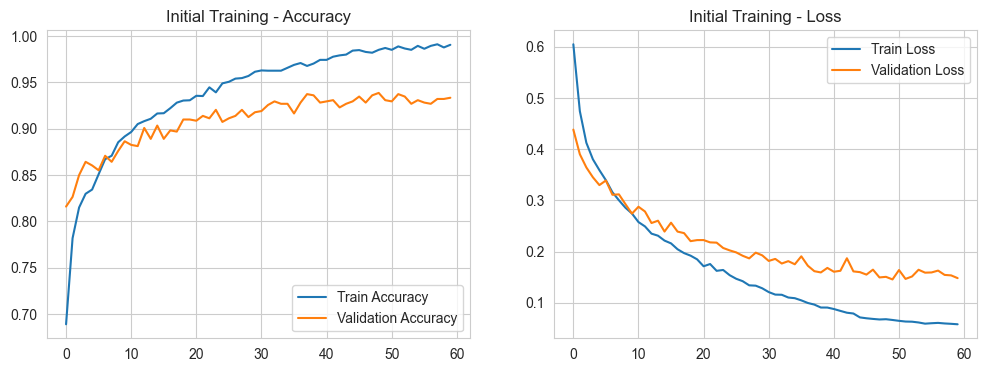

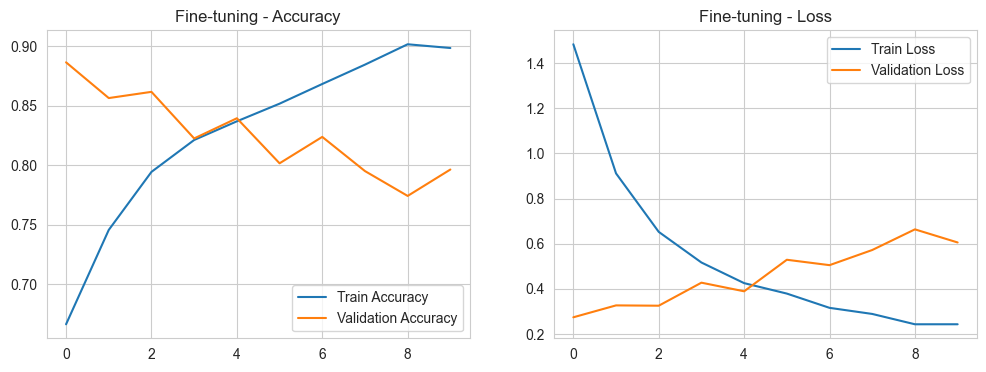

In [25]:
# Plot the training history
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.legend()
    ax1.set_title(f'{title} - Accuracy')

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.legend()
    ax2.set_title(f'{title} - Loss')

    plt.show()

plot_history(history, 'Initial Training')
plot_history(history_fine, 'Fine-tuning')

In [26]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8900 - loss: 0.2554
Validation Accuracy: 89.03%
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9078 - loss: 0.2928
Test Accuracy: 90.35%


In [27]:
# Generate confusion matrix for the test set
test_data_unbatched = test_data.unbatch()
y_pred = []
y_true = []

for x, y in test_data_unbatched:
    x = tf.expand_dims(x, axis=0)
    pred = model.predict(x)
    y_pred.append(1 if pred >= 0.5 else 0)
    y_true.append(int(y.numpy()))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/x3/jh_7mg9d1sx0rl54wqhg5gr00000gn/T/ipykernel_64949/2750763198.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true.append(int(y.numpy()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

2024-06-08 01:15:31.567538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix, without normalization


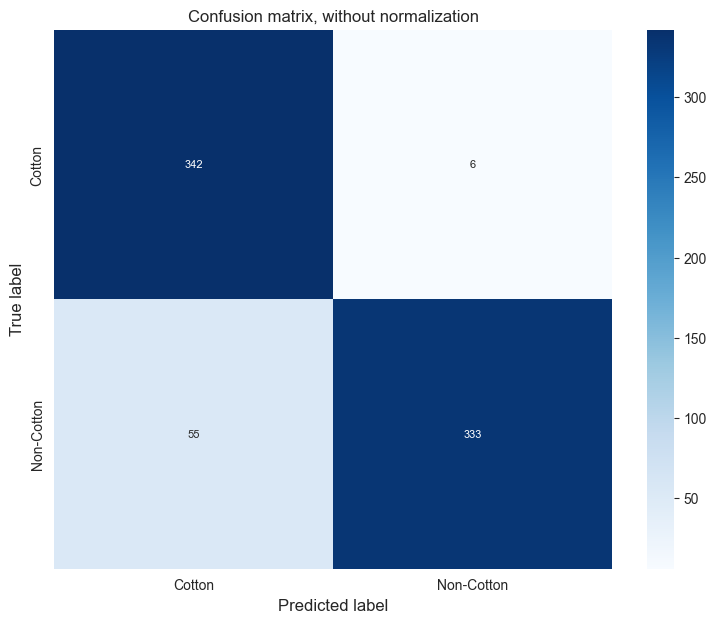

Normalized confusion matrix


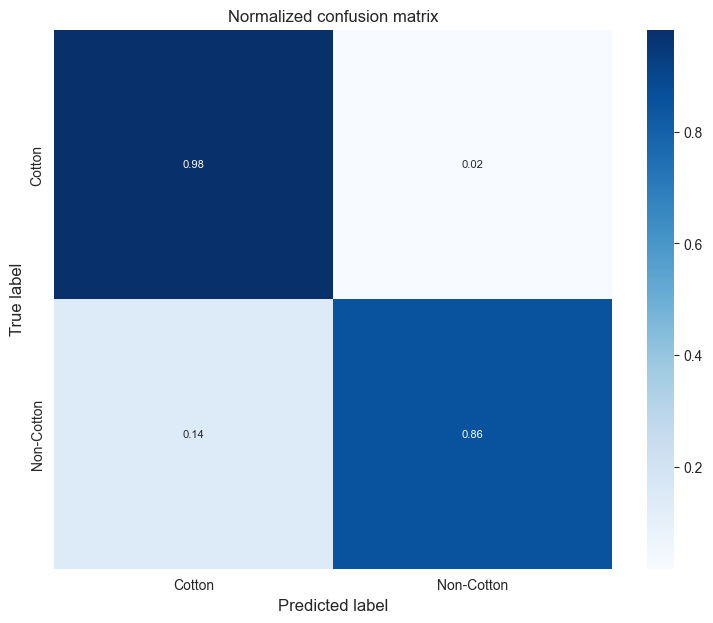

In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.nan_to_num(cm)  # Replace nan with 0 and inf with large finite numbers
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(title, fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')


In [29]:
import os

# File path for the saved model
model_file_path = './models/fabric_classification_model_binary_cotton.keras'  # Changed the file name to ensure it doesn't exist

# Check if the file already exists and remove it (optional, since we are using a new name)
if os.path.exists(model_file_path):
    os.remove(model_file_path)

# Save the trained model to a file using the recommended format
model.save(model_file_path)
